In [ ]:
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

from shapely.geometry import Point

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from pathos.multiprocessing import ProcessingPool as Pool

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon, spatial_correlation
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

In [2]:
yy_s, yy_e = 2001, 2017

In [5]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'
maxmiss = 50

In [6]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [ ]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    # DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 477MB
Dimensions:  (time: 49672, lat: 30, lon: 40)
Coordinates:
  * time     (time) datetime64[ns] 397kB 2001-01-01 ... 2017-12-31T21:00:00
  * lat      (lat) float32 120B 44.05 44.15 44.25 44.35 ... 46.75 46.85 46.95
  * lon      (lon) float32 160B 10.05 10.15 10.25 10.35 ... 13.75 13.85 13.95
Data variables:
    PRE      (time, lat, lon) float64 477MB ...
Attributes:
    description:  IMERG 3 hour data for Veneto region

In [195]:
OBS_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull','VENETO_WEIBULL_OBS_1981_2023.nc')
OBS = xr.open_dataset(OBS_dir)
POS = np.argwhere(~np.isnan(np.nanmean(OBS['Wetdays'].values,axis=0)))

In [ ]:
def ART_downscalling(DATA_in, lat_c, lon_c, PARAM):
    PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)

    DATES_daily = PRE_daily['time']

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data

    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
                IMERG_pixel_1dy_xr, 
                thresh=PARAM['thresh'], 
                maxmiss=PARAM['maxmiss'])

    box_3h, bcond = create_box(DATA, lat_c, lon_c, PARAM['npix'], reso=0.1)

    smax = box_3h.shape[0] # max spatial scale
    tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    tscales = tscales[tscales < PARAM['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*PARAM['L1']
    ntscales = np.size(tscales)
    nsscales = np.size(xscales)

    WET_MATRIX = space_time_scales_agregations(
                box_3h, 
                PARAM['L1'], 
                CONDITION, 
                tscales, 
                xscales, 
                PARAM['npix'], 
                PARAM['thresh'])

    xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)
    ntscales = np.size(tscales)
    nxscales = np.size(xscales)

    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), PARAM['ninterp'])
    WET_MATRIX_INTER = np.zeros((PARAM['ninterp'], nxscales))
    
    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                PARAM['L1'], 
                PARAM['npix'])

    origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
    target_ref = [PARAM['target_x'], PARAM['target_t']]

    beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    vdist, vcorr, distance_vector = autocorrelation_neighborhood(
                box_3h, 
                t_target = PARAM['target_t'], 
                thresh = PARAM['thresh'], 
                cor_method = PARAM['corr_method'])

    FIT, _ = curve_fit(str_exp_fun, vdist, vcorr)
    FIT_d0, FIT_mu0 = FIT
    FIT, _ = curve_fit(epl_fun, vdist, vcorr)
    FIT_eps, FIT_alp = FIT

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation
    
    FIT, _ = curve_fit(epl_fun, vdist_ave, vcorr_ave)
    FIT_ave_eps, FIT_ave_alp = FIT

    # bounds = [(0.0, 200),(0, 1)] # ORIGINAL LIMITS BY ZORZETO
    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO
    
    def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    with Pool(nodes=PARAM['cores']) as pool:
        resmin = differential_evolution(
            myfun,
            bounds,
            disp=True,
            tol=0.05,
            atol=0.05,
            workers=pool.map
        )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    NYd, CYd, WYd, gamYd, _ = down_wei(
                        IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        beta, 
                        (param1, param2), 
                        acf=PARAM['acf'])

    DOWN_WEIBULL_YY = np.zeros([len(NYd), 3])
    DOWN_WEIBULL_YY[:,0] = NYd
    DOWN_WEIBULL_YY[:,1] = CYd
    DOWN_WEIBULL_YY[:,2] = WYd

    dict_out = dict({'beta':beta, 'gamma':gamYd, 'param1':param1, 'param2':param2})

    return IMERG_WEIBULL_YEAR, DOWN_WEIBULL_YY, dict_out

In [ ]:
parameters = dict({
    'L0':0,
    'L1':10,
    
    'maxmiss':40,

    'npix':5,
    'thresh': 2,
    'tmax': 48,
    'dt': 3,
    
    'origin_x': 10,
    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'cores': 12,
})

In [208]:
IMERG_WD = np.zeros([17,len(lats),len(lons)])*np.nan
IMERG_SC = np.zeros([17,len(lats),len(lons)])*np.nan
IMERG_SH = np.zeros([17,len(lats),len(lons)])*np.nan

DOWN_WD = np.zeros([17,len(lats),len(lons)])*np.nan
DOWN_SC = np.zeros([17,len(lats),len(lons)])*np.nan
DOWN_SH = np.zeros([17,len(lats),len(lons)])*np.nan

M_beta = np.zeros([len(lats),len(lons)])*np.nan
M_gamma = np.zeros([len(lats),len(lons)])*np.nan

In [ ]:
for la, lo in POS:
    IMERG_WEIBULL_YY, DOWN_WEIBULL_YY, dict_out, = ART_downscalling(DATA, lats[la], lons[lo], parameters)
    IMERG_WD[:,la,lo] = IMERG_WEIBULL_YY[:,0]
    DOWN_WD[:,la,lo] = DOWN_WEIBULL_YY[:,0]
    M_beta[la,lo] = dict_out['beta']
    M_gamma[la,lo] = dict_out['gamma']

Scales agregation condition: OVERLEAP

Number of clusters: 22
differential_evolution step 1: f(x)= 0.006055300892399017
differential_evolution step 2: f(x)= 0.005077747809667462
differential_evolution step 3: f(x)= 0.0028119022675621194
Polishing solution with 'L-BFGS-B'
Gamma value: 0.9668522289711898
Scales agregation condition: OVERLEAP

Number of clusters: 22
differential_evolution step 1: f(x)= 0.007672850412945281
differential_evolution step 2: f(x)= 0.007672850412945281
differential_evolution step 3: f(x)= 0.005220670715776956
Polishing solution with 'L-BFGS-B'
Gamma value: 0.966437788635225


In [221]:
170*7/60

19.833333333333332

In [210]:
# ii = 10
# jj = 15

# IMERG_WEIBULL_YY, DOWN_WEIBULL_YY, dict_out, = ART_downscalling(DATA, lats[ii], lons[jj], parameters)

In [ ]:
(M_gamma)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

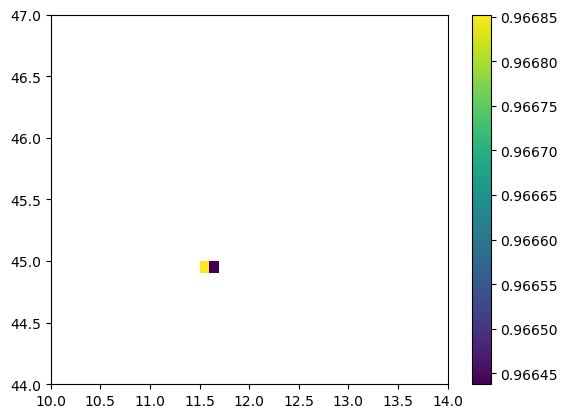

In [218]:
plt.pcolormesh(lon2d, lat2d, M_gamma)
plt.colorbar()

In [191]:
TEST = np.zeros([30,40])
for la, lo in POS:
    TEST[la,lo] = 1

In [ ]:
# fig = plt.figure(figsize=(12,4),dpi=300)
# gs = gridspec.GridSpec(1,3)

# # ===========================================================================
# ax1 = plt.subplot(gs[0,0])
# ax1.plot(IMERG_WEIBULL_YY[:,3], IMERG_WEIBULL_YY[:,0], c='g', label='IMERG')
# ax1.plot(IMERG_WEIBULL_YY[:,3], DOWN_WEIBULL_YY[:,0], c='b', label='down')
# ax1.legend(fontsize=6, ncol=3)
# ax1.set_title('(a) Wet Days', loc='left', fontsize=9)
# ax1.set_title(f'thresh IMERG: {parameters['thresh']}', loc='right', fontsize=9)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(25,240)
# ax1.grid(linewidth=0.3, linestyle='--')

# ax1 = plt.subplot(gs[0,1])
# ax1.plot(IMERG_WEIBULL_YY[:,3], IMERG_WEIBULL_YY[:,1], c='g', label='IMERG')
# ax1.plot(IMERG_WEIBULL_YY[:,3], DOWN_WEIBULL_YY[:,1], c='b', label='down')
# ax1.legend(fontsize=6, ncol=3)
# ax1.set_title('(b) Scale', loc='left', fontsize=9)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(1,19)
# ax1.grid(linewidth=0.3, linestyle='--')

# ax1 = plt.subplot(gs[0,2])
# ax1.plot(IMERG_WEIBULL_YY[:,3], IMERG_WEIBULL_YY[:,2], c='g', label='IMERG')
# ax1.plot(IMERG_WEIBULL_YY[:,3], DOWN_WEIBULL_YY[:,2], c='b', label='down')
# ax1.legend(fontsize=6, ncol=3)
# ax1.set_title('(c) Shape', loc='left', fontsize=9)
# ax1.set_title(f'acf: {parameters['acf']}',loc='center',fontsize=9)
# # ax1.set_title(f'nclust: {nclust}',loc='right',fontsize=9)
# ax1.xaxis.set_tick_params(labelsize=7)
# ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(0.4,1.2)
# ax1.grid(linewidth=0.3, linestyle='--')
